In [19]:
import py_trees
import behaviours as be
from py_trees.blackboard import Blackboard
import pandas as pd
from scipy import spatial
from sklearn.cluster import KMeans
import numpy as np
from pandas import DataFrame
from annotator import annotator
import re
import matplotlib.pyplot as plt

In [2]:
# read labeled cases
docu = '/Users/sileshu/Desktop/EMSData/RAA Data 2.xlsx'
df = pd.read_excel(docu)
su = 0
protocol = {}
narratives = df['Narrative']
vitals = df['Vitals']
inters = df['Interventions']
gt = []
pts = set()
for item in df['HAYDON LABEL']:
    if not pd.isnull(item):
        gt.append(item)
        pts.add(item)

intermapping= {
    '12-lead ecg':['cardiac monitor'],
    'albuterol':['albuterol'],
    'aspirin':['aspirin'],
    'assist ventilation (bvm)':['bag valve mask ventilation'],
    'capnography (1) first reading':['capnography'],
    'capnography (2) seco':['capnography'],
    'capnography (2) second reading':['capnography'],
    'capnography (3) final reading':['capnography'],
    'cardiac monitor':['cardiac monitor'],
    'nasopharyngeal airway insertio':['nasopharyngeal airway'],
    'cpap':['cpap'],
    'dexamethasone (decadron)':['dexamethasone'],
    'dextrose 10%':['dextrose'],
    'dextrose 25%':['dextrose'],
    'duoneb':['albuterol','ipratropium'],
    'fentanyl':['fentanyl'],
    'glucagon':['glucagon'],
    'glutose':['oral glucose'],
    'hospital':['transport'],
    'hospital contact':['transport'],
    'intubation':['endotracheal tube'],
    'ipratropium (atrovent)':['ipratropium'],
    'iv':['normal saline'],
    'magnesium sulfate':['morphine sulfate'],
    'midazolam (versed)':['midazolam'],
    'naloxone (narcan)':['narcan'],
    'nitroglycerine':['nitroglycerine'],
    'normal saline':['normal saline'],
    'ondansetron (zofran)':['ondansetron'],
    'oral glucose':['oral glucose'],
    'oxygen':['oxygen'],
    'restraints':['physical restraint'],
    'suction':['suction the oropharynx','suction the nasopharynx'],
}
interventions = []
for item in inters:
    inter = item.strip('{}').split('}{')
    inter = [i.split(':')[-1].strip().lower() for i in inter]
    c_int = []
    for j in inter:
        if j in intermapping:
            c_int += intermapping[j]
        else:
            print j
    interventions.append(c_int)


travel
cold pack
02
oropharyngeal airway insertion

bleeding controlled
open airway
30
oropharyngeal airway insertion
ziprasidone (geodon)
oropharyngeal airway insertion
vagal maneuver
bleeding controlled
travel
open airway
oropharyngeal airway insertion



In [6]:
# build concept list
from search_term import search_term

In [3]:
pro_df = pd.read_excel('/Users/sileshu/Desktop/BT/ODEMSA_Protocols_weighted.xlsx')

In [4]:
ss = set()
inter = set()
for item in pro_df['Signs&Symptoms']:
    for i in item.split(';'):
        i = (i.strip().lower()[:-1],i.strip().lower()[-1])
        ss.add(i[0])
for item in pro_df['Interventions']:
    for i in item.split(';'):
        i = (i.strip().lower()[:-1],i.strip().lower()[-1])
        inter.add(i[0])
for item in pro_df['Possible signs&symptoms additions']:
    if pd.isnull(item):
        continue
    for i in item.split(';'):
        i = (i.strip().lower()[:-1],i.strip().lower()[-1])
        ss.add(i[0])

In [8]:
len(inter)

40

In [71]:
dft = pd.DataFrame()
dft['Required Concepts'] = list(ss)
dft.to_csv('RC.csv',index = False)

In [7]:
concept_mapping = {}
for i in ss:
    cuis = search_term(i, page_limit = 1, check = True)
    if len(cuis) == 0:
        print i
    else:
        concept_mapping[i] = cuis

In [14]:
concept_mapping = {}
for i in inter:
    cuis = search_term(i, page_limit = 1, check = True)
    if len(cuis) == 0:
        print i
    else:
        concept_mapping[i] = cuis

In [15]:
concept_mapping.keys()

[u'glucagon',
 u'epinephrine',
 u'nitroglycerin',
 u'transport',
 u'diazepam',
 u'fentanyl',
 u'midazolam',
 u'normal saline',
 u'encourage patient to relax',
 u'oral glucose',
 u'recovery position',
 u'supine position',
 u'narcan',
 u'albuterol',
 u'cpap',
 u'bag valve mask ventilation',
 u'morphine',
 u'metered dose inhaler',
 u'physical restraint',
 u'nasopharyngeal airway',
 u'capnography',
 u'suction the oropharynx',
 u'ondansetron',
 u'dexamethasone',
 u'cardiac monitor',
 u'geodon',
 u'ipratropium',
 u'oxygen',
 u'magnesium sulfate',
 u'dextrose',
 u'suction the nasopharynx',
 u'endotracheal tube',
 u'bronchodilator',
 u'aspirin']

In [16]:
dfs = []
for i in concept_mapping:
    df = DataFrame()
    cuis = [j[0] for j in concept_mapping[i]]
    names = [j[1] for j in concept_mapping[i]]
    concept = [i] + [np.nan] * (len(cuis) - 1)
    df['Required Concept'] = concept
    df['CUI'] = cuis
    df['Preferred Name'] = names
    dfs.append(df)
concept_list = pd.concat(dfs)

In [17]:
concept_list.to_csv('concept_list(interventions).csv',index = False)

In [13]:
# cluster protocol
pv = {}
for line in pro_df.iterrows():
    sv = []
    iv = []
    line_ss = [(i.strip().lower()[:-1],i.strip().lower()[-1]) for i in line[1]['Signs&Symptoms'].split(';')]
    line_inter = [(i.strip().lower()[:-1],i.strip().lower()[-1]) for i in line[1]['Interventions'].split(';')]
    if not pd.isnull(line[1]['Possible signs&symptoms additions']):
        line_ssr = [(i.strip().lower()[:-1],i.strip().lower()[-1]) for i in line[1]['Possible signs&symptoms additions'].split(';')]
    line_ss += line_ssr
    print line_ss
    name = line[1]['Protocol']
    for i in ss:
        res = 0.
        for j in line_ss:
            if i[0] == j[0]:
                res = 2.**int(j[1])
                break;
        sv.append(res)
    #for j in inter:
     #   iv.append(int(j in line_inter))
    pv[name] = sv
            

[(u'chest pain', u'3'), (u'pain region', u'2'), (u'pain radiation', u'3'), (u'pale', u'3'), (u'diaphoresis', u'3'), (u'shortness of breath', u'2'), (u'nausea', u'2'), (u'vomiting', u'2'), (u'dizziness', u'1'), (u'chest pressure', u'3'), (u'pain chest wall', u'2'), (u'pain jaw', u'2'), (u'chest tightness', u'2')]
[(u'pain', u'3'), (u'distension', u'3'), (u'rigidity', u'3'), (u'unequal femoral pulses', u'1'), (u'absent femoral pulses', u'1'), (u'diaphoresis', u'2'), (u'tenderness', u'2'), (u'nausea', u'3'), (u'vomiting', u'3'), (u'diarrhea', u'3'), (u'dysuria', u'3'), (u'constipation', u'3'), (u'vaginal bleeding', u'3'), (u'vaginal discharge', u'2'), (u'pregnancy', u'3'), (u'fever', u'3'), (u'headache', u'2'), (u'weakness', u'2'), (u'malaise', u'2'), (u'myalgias', u'2'), (u'cough', u'1'), (u'rash', u'1'), (u'rebound tenderness', u'3')]
[(u'anxiety', u'2'), (u'agitation', u'3'), (u'confusion', u'2'), (u'hallucinations', u'3'), (u'delusional thoughts', u'2'), (u'bizarre behavior', u'2'), (

In [27]:
l = []
names = []
for i in pv:
    names.append(i)
    l.append(pv[i])
X = np.array(l)
kmeans = KMeans(n_clusters = 4, random_state=0).fit(X)

In [28]:
kmeans.labels_

array([3, 1, 0, 2, 0, 1, 2, 1, 0], dtype=int32)

In [29]:
names

[u'Medical - Abdominal Pain',
 u'General - Pain Control',
 u'Medical - Altered Mental Status',
 u'Medical - Seizure',
 u'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway',
 u'General - Behavioral/Patient Restraint',
 u'Medical - Overdose/Poisoning - Opioid',
 u'Medical - Diabetic - Hypoglycemia',
 u'Medical - Chest Pain - Cardiac Suspected']

In [30]:
group = dict()
x = kmeans.labels_
for i,name in enumerate(names):
    if x[i] in group:
        group[x[i]].append(name)
    else:
        group[x[i]] = [name]

In [16]:
from tqdm import tqdm_notebook as tqdm
EKGset = set()
pred_int = []
EKGdic = {
     '':'',
     'AV_Block_1st_Deg':'AV_Block-1st_Degree',
     'AV_Block_1st_Degree':'AV_Block-1st_Degree',
     'AV_Block_1st_Degree,Sinus_Rhythm':'AV_Block-1st_Degree,Sinus_Rhythm',
     'AV_Block_2nd_Degree_Type_1':'AV_Block_2nd_Degree_Type_1',
     'Asystole':'Asystole',
     'Artifact':'Artifact',
     'Atrial_Fibrill':'Atrial_Fibrillation',
     'Atrial_Fibrillation':'Atrial_Fibrillation',
     'Atrial_Flutter':'Atrial_Flutter',
     'Juncti':'Junctional_Rhythm',
     'Junctiona':'Junctional_Rhythm',
     'Junctional':'Junctional_Rhythm',
     'Other_(Not_Listed)':'Other_(Not_Listed)',
     'P': 'Paced_Rhythm',
     'PEA':'Pulseless_Electrical_Activity',
     'Pac':'Paced_Rhythm',
     'Paced_Rhythm':'Paced_Rhythm',
     'Premature_Ventricular_Contractions,,Sinus_Rhythm':'Premature_Ventricular_Contractions,Sinus_Rhythm',
     'Premature_Ventricular_Contractions,Sinus_Rhythm':'Premature_Ventricular_Contractions,Sinus_Rhythm',
     'Right_Bundle_Branch_Block':'Right_Bundle_Branch_Block',
     'STEMI_Anterior_Ischemia':'STEMI_Anterior_Ischemia',
     'STEMI_Lateral_Ischemia':'STEMI_Lateral_Ischemia',
     'S':'Sinus_Rhythm',
     'Si':'Sinus_Rhythm',
     'Sin':'Sinus_Rhythm',
     'Sinu':'Sinus_Rhythm',
     'Sinus':'Sinus_Rhythm',
     'Sinus_':'Sinus_Rhythm',
     'Sinus_Arrhythmia':'Sinus_Arrhythmia',
     'Sinus_Arrhythmia,Sinus_Rhythm':'Sinus_Arrhythmia,Sinus_Rhythm',
     'Sinus_Arrhythmia,Sinus_Tachycardia':'Sinus_Arrhythmia,Sinus_Tachycardia',
     'Sinus_Bradycardia':'Sinus_Bradycardia',
     'Sinus_R':'Sinus_Rhythm',
     'Sinus_Rh':'Sinus_Rhythm',
     'Sinus_Rhy':'Sinus_Rhythm',
     'Sinus_Rhyth':'Sinus_Rhythm',
     'Sinus_Rhythm':'Sinus_Rhythm',
     'Sinus_T':'Sinus_Tachycardia',
     'Sinus_Tach':'Sinus_Tachycardia',
     'Sinus_Tachyc':'Sinus_Tachycardia',
     'Sinus_Tachycardi':'Sinus_Tachycardia',
     'Sinus_Tachycardia':'Sinus_Tachycardia',
     'Supravent':'Supraventricular_Tachycardia',
     'Supraventricular_Tachycardia':'Supraventricular_Tachycardia',
     'Ventricular_Fibrillation':'Ventricular_Fibrillation',
     'Ventricular_Tachycardia_(With_Pulse)':'Ventricular_Tachycardia'
}
# extract concept and calculate similarity
from ranking_func import rank
pool = set(['Medical - Abdominal Pain',
            'Medical - Altered Mental Status',
            'Medical - Seizure',
            'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway',
            'General - Behavioral/Patient Restraint',
            'Medical - Overdose/Poisoning - Opioid',
            'Medical - Diabetic - Hypoglycemia',
            'Medical - Chest Pain - Cardiac Suspected'])

def pre_tick_handler(behaviour_tree):
    blackboard = Blackboard()
    blackboard.tick_num += 1
results = []
scores = []
ConceptRes = []
for i,item in enumerate(tqdm(narratives)):
    vt = vitals[i].strip('{}').split('}{')
    vt = [it.split(':')[-1] for it in vt]
    for idx,it in enumerate(vt):
        if 'EKG-' in it:
            temp = it.split('EKG-')
            temp[1] = temp[1].replace(' ','_')
            temp[1] = temp[1].replace('-','_')
            vt[idx] = temp[0] + 'EKG-' + EKGdic[temp[1]]
            if len(temp[1]) > 0:
                EKGset.add(temp[1])
    vt = [ite for l in vt for ite in l.strip().split(' ')]
    for idx in xrange(len(vt)):
        if idx < len(vt) and '-' not in vt[idx]:
            vt.pop(idx)
    for idx,it in enumerate(vt):
        temp = it.split('-')
        vt[idx] = (temp[0],temp[1])
    blackboard = Blackboard()
    blackboard.text = [item]
    root = py_trees.composites.Sequence("Root_1")
    IG = be.InformationGathering(inC = vt)
    TC = be.TextCollection()
    V = be.Vectorize()
    PS = be.ProtocolSelector()
    root.add_children([TC,IG,V,PS,be.protocols])
    behaviour_tree = py_trees.trees.BehaviourTree(root)
    behaviour_tree.add_pre_tick_handler(pre_tick_handler)
    behaviour_tree.setup(15)
    behaviour_tree.tick_tock(
            sleep_ms=50,
            number_of_iterations=1,
            pre_tick_handler=None,
       post_tick_handler=None
        )
    scores.append(blackboard.ranking)
    ConceptRes.append(blackboard.ConcLog)
    results.append(blackboard.candi)
    res = []
    for key in blackboard.feedback:
        if blackboard.feedback[key] > 0.1:
            res.append(key)
    pred_int.append(res)
    

(normal saline;True;normal saline;normal saline;673.0;1)
(capnography;True;capnography;capnography;1000.0;1)
(morphine;True;heroin;heroin;604.0;1)
(cardiac monitor;True;cardiac monitoring;cardiac monitoring;1000.0;1)
(transport;True;992;transferred;790.0;1)
(albuterol;True;3;albuterol;586.0;1)
(oxygen;True;6;o2;1000.0;1)
(transport;True;transported;transported;719.0;1)
(cardiac monitor;True;cardiac monitor;cardiac monitor;1000.0;1)
(transport;True;transport;transport;660.0;1)
(cardiac monitor;True;cardiac monitor;cardiac monitor;694.0;1)
(transport;True;transferred;transferred;604.0;1)
(transport;True;transferred;transferred;770.0;1)
(cardiac monitor;True;cardiac monitor;cardiac monitor;1000.0;1)
(transport;True;transferred;transferred;753.0;1)
(normal saline;True;flushed normal saline;flushed normal saline;804.0;1)
(supine position;True;supine;supine;770.0;1)
(physical restraint;True;restraint;restraint;753.0;1)
(aspirin;True;asa;asa;1000.0;1)
(transport;True;transported;transported;7

(transport;True;transferred;transferred;790.0;1)
(aspirin;True;2;asa;827.0;1)
(transport;True;transport;transport;753.0;1)
(supine position;True;lying;lying;770.0;1)
(cardiac monitor;True;cardiac monitor;cardiac monitor;1000.0;1)
(transport;True;transferred;transferred;770.0;1)
(cardiac monitor;True;12;cardiac monitor;833.0;1)
(aspirin;True;aspirin;aspirin;770.0;1)
(transport;True;transferred;transferred;760.0;1)
(supine position;True;supine position;supine position;1000.0;1)
(narcan;True;narcan;narcan;632.0;1)
(cardiac monitor;True;2;cardiac monitor;640.0;1)
(oxygen;True;o2;o2;812.0;1)
(transport;True;transported;transported;704.0;1)
(oral glucose;True;oral glucose;oral glucose;600.0;1)
(dextrose;True;glucose;glucose;578.0;1)
(transport;True;transported;transported;799.0;1)
(supine position;True;lying;lying;1000.0;1)
(narcan;True;narcan;narcan;623.0;1)
(morphine;True;heroin;heroin;1000.0;1)
(transport;True;transferred;transferred;760.0;1)
(dexamethasone;True;0;dexamethasone;645.0;1)
(

(transport;True;transferred;transferred;790.0;1)
(narcan;True;narcan;narcan;827.0;1)
(morphine;True;heroin;heroin;604.0;1)
(cardiac monitor;True;1;cardiac monitor;833.0;1)
(oxygen;True;o2;o2;861.0;1)
(transport;True;transferred;transferred;770.0;1)
(capnography;True;capnography monitoring;capnography monitoring;1000.0;1)
(transport;True;transferred;transferred;790.0;1)
(transport;True;transferred;transferred;790.0;1)
(albuterol;True;albuterol;albuterol;586.0;1)
(transport;True;transferred;transferred;760.0;1)
(cpap;True;cpap;cpap;694.0;1)
(oxygen;True;2;o2;581.0;1)
(aspirin;True;asa;asa;748.0;1)
(transport;True;transport;transport;1000.0;1)
(oral glucose;True;oral glucose;oral glucose;631.0;1)
(transport;True;transported;transported;726.0;1)
(normal saline;True;normal saline;normal saline;666.0;1)
(cardiac monitor;True;cardiac monitor;cardiac monitor;806.0;1)
(ondansetron;True;ondansetron;ondansetron;770.0;1)
(transport;True;transported;transported;756.0;1)
(transport;True;transported;

(transport;True;transported;transported;719.0;1)
(transport;True;transport;transport;586.0;1)
(albuterol;True;0.5;albuterol;760.0;1)
(oxygen;True;o2;o2;1000.0;1)
(transport;True;transferred;transferred;790.0;1)
(albuterol;True;albuterol;albuterol;1000.0;1)
(capnography;True;capnography;capnography;861.0;1)
(cardiac monitor;True;12;cardiac monitor;1000.0;1)
(oxygen;True;3;oxygen;760.0;1)
(dextrose;True;glucose;glucose;827.0;1)
(transport;True;transferred;transferred;790.0;1)
(dextrose;True;5;glucose;660.0;1)
(normal saline;True;normal saline;normal saline;1000.0;1)
(supine position;True;supine;supine;744.0;1)
(transport;True;12;transferred;790.0;1)
(supine position;True;supine;supine;748.0;1)
(cardiac monitor;True;cardiac monitoring;cardiac monitoring;651.0;1)
(transport;True;transferred;transferred;770.0;1)
(cardiac monitor;True;12;cardiac monitoring;1000.0;1)
(transport;True;transport;transport;593.0;1)
(supine position;True;supine;supine;770.0;1)
(oxygen;True;o2;o2;1000.0;1)
(transpo

(transport;True;transferred;transferred;753.0;1)
(normal saline;True;flushed normal saline;flushed normal saline;804.0;1)
(physical restraint;True;restraint;restraint;753.0;1)
(oxygen;True;o2;o2;760.0;1)
(aspirin;True;asa;asa;1000.0;1)
(transport;True;transferred;transferred;770.0;1)
(midazolam;True;midazolam;midazolam;593.0;1)
(supine position;True;lying;lying;739.0;1)
(cardiac monitor;True;cardiac monitor;cardiac monitor;806.0;1)
(oxygen;True;oxygen;oxygen;861.0;1)
(transport;True;transferred;transferred;770.0;1)
(cardiac monitor;True;12;cardiac monitor;1000.0;1)
(transport;True;transport;transport;586.0;1)
(morphine;True;heroin;heroin;753.0;1)
(oxygen;True;o2;o2;593.0;1)
(transport;True;carried;carried;790.0;1)
(supine position;True;lying;lying;770.0;1)
(narcan;True;2;narcan;744.0;1)
(physical restraint;True;restraints;restraints;770.0;1)
(capnography;True;capnography;capnography;660.0;1)
(cardiac monitor;True;cardiac monitor;cardiac monitor;833.0;1)
(oxygen;True;oxygen;oxygen;586.0

In [17]:
TP = 0.
FP = 0.
FN = 0.
fpst = dict()
fnst = dict()
fps = []
fns = []

precisions = []
recalls = []
f1scores = []
for i,item in enumerate(pred_int):
    TP = 0.
    FP = 0.
    FN = 0.
    fp = []
    fn = []
    for m in item:
        if m in interventions[i]:
            TP += 1
        else:
            if m in fpst:
                fpst[m] += 1
            else:
                fpst[m] = 1
            FP += 1
            fp.append(m)
    for n in interventions[i]:
        if n not in pred_int[i]:
            if n in fnst:
                fnst[n] += 1
            else:
                fnst[n] = 1
            FN += 1
            fn.append(n)
    fps.append(fp)
    fns.append(fn)
    if TP == 0 and FP == 0:
        recalls.append(TP / (TP + FN))
        precisions.append(0.)
        f1scores.append(2 * TP / (2 * TP + FN + FP))
        continue
    recalls.append(TP / (TP + FN))
    precisions.append(TP / (TP + FP))
    f1scores.append(2 * TP / (2 * TP + FN + FP))

In [18]:
fns

[['bag valve mask ventilation'],
 ['albuterol', 'ipratropium', 'oxygen'],
 [],
 [],
 [],
 [],
 ['normal saline'],
 [],
 [],
 [],
 ['oxygen'],
 [],
 [],
 [],
 [],
 ['bag valve mask ventilation', 'narcan'],
 [],
 [],
 [],
 ['albuterol', 'ipratropium'],
 [],
 [],
 [],
 [],
 [],
 ['aspirin'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['oxygen'],
 [],
 [],
 [],
 ['cardiac monitor', 'normal saline', 'transport', 'midazolam'],
 [],
 ['oral glucose'],
 ['aspirin'],
 ['albuterol',
  'ipratropium',
  'normal saline',
  'dexamethasone',
  'morphine sulfate',
  'albuterol',
  'ipratropium'],
 [],
 ['oxygen'],
 ['nasopharyngeal airway', 'dextrose'],
 [],
 [],
 ['albuterol', 'ipratropium'],
 [],
 ['albuterol', 'ipratropium', 'normal saline'],
 ['normal saline', 'normal saline'],
 ['normal saline'],
 ['normal saline'],
 [],
 ['midazolam'],
 [],
 [],
 [],
 ['aspirin'],
 [],
 [],
 ['oxygen'],
 [],
 ['normal saline'],
 ['normal saline', 'cpap'],
 [],
 [],
 ['oxygen'],
 [],
 ['albuterol', '

In [19]:
ct = 0
fnc = 0
fpc = 0
for i in range(len(fns)):
    if len(fns[i]) == 0 and len(fps[i]) == 0:
        ct += 1
    if len(fns[i]) == 0:
        fpc += 1
    if len(fps[i]) == 0:
        fnc += 1
ct,fnc,fpc

(44, 94, 149)

In [20]:
df['FN'] = fns
df['FP'] = fps

In [21]:
fnst

{'albuterol': 36,
 'aspirin': 8,
 'bag valve mask ventilation': 16,
 'capnography': 8,
 'cardiac monitor': 2,
 'cpap': 4,
 'dexamethasone': 7,
 'dextrose': 11,
 'fentanyl': 1,
 'glucagon': 1,
 'ipratropium': 33,
 'midazolam': 9,
 'morphine sulfate': 3,
 'narcan': 10,
 'nasopharyngeal airway': 10,
 'nitroglycerine': 3,
 'normal saline': 41,
 'ondansetron': 4,
 'oral glucose': 5,
 'oxygen': 46,
 'physical restraint': 7,
 'suction the nasopharynx': 2,
 'suction the oropharynx': 2,
 'transport': 1}

In [22]:
fpst

{'aspirin': 51,
 'bag valve mask ventilation': 24,
 'cardiac monitor': 9,
 'cpap': 8,
 'dexamethasone': 13,
 'dextrose': 3,
 'midazolam': 3,
 'narcan': 39,
 'nitroglycerin': 1,
 'normal saline': 60,
 'ondansetron': 24,
 'oral glucose': 12,
 'oxygen': 27,
 'physical restraint': 4,
 'transport': 16}

In [23]:
df.to_excel('RAA_286_Feedback_Res_Modified.xlsx',index = False)

In [24]:
print 'M-precision:' + '%.3f'%(sum(precisions)/len(precisions))
print 'M-recall:' + '%.3f'%(sum(recalls)/len(recalls))
print 'M-F1-score:' + '%.3f'%(sum(f1scores)/len(f1scores))

M-precision:0.760
M-recall:0.814
M-F1-score:0.757


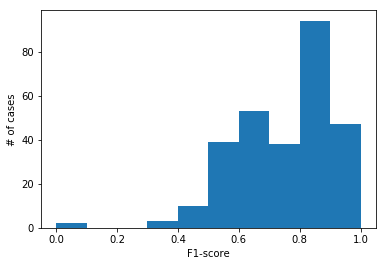

In [25]:
fig = plt.hist(f1scores)
plt.xlabel('F1-score')
plt.ylabel('# of cases')
plt.show()

In [26]:
bina = []
for i,r in enumerate(results):
    bina.append(gt[i] in r[:3])
print float(sum(bina))/len(bina)
        

0.832167832168


In [11]:
sum(bina)

229

In [23]:
Inters = []
for item in interventions1:
    inter = item.strip('{}').split('}{')
    inter = [i.split(':')[-1].strip().lower() for i in inter]
    Inters.append(inter)
interset = set()
for i in Inters:
    for j in i:
        interset.add(j)

In [24]:
interset

{u'',
 u'1',
 u'10,',
 u'10,000',
 u'12-lead ecg',
 u'13',
 u'2',
 u'30',
 u'adenosine (adenocard)',
 u'aed',
 u'albuterol',
 u'amiodarone (bolus)',
 u'aspirin',
 u'assist ventilation (bvm)',
 u'bleeding controlled',
 u'capnography (1) first reading',
 u'capnography (2) seco',
 u'capnography (2) second reading',
 u'cardiac monitor',
 u'chest decompression',
 u'cold pack',
 u'cpap',
 u'cpr',
 u'defibrillation',
 u'dexamethasone (decadron)',
 u'dextrose 10%',
 u'dextrose 25%',
 u'diphenhydramine (benadryl)',
 u'duoneb',
 u'fentanyl',
 u'glucagon',
 u'glutose',
 u'hospital',
 u'hospital contact',
 u'intraosseus',
 u'intubation',
 u'ipratropium (atrovent)',
 u'iv',
 u'king ltsd airway',
 u'magnesium sulfate',
 u'midazolam (versed)',
 u'naloxone (narcan)',
 u'nasopharyngeal airway insertio',
 u'nitroglycerine',
 u'normal saline',
 u'occlusive dressing',
 u'ondansetron (zofran)',
 u'open airway',
 u'oral glucose',
 u'oropharyngeal airway insertion',
 u'oxygen',
 u'pulse oximetry',
 u'restrai

In [49]:
protocol2inter = {
    'Medical - Chest Pain - Cardiac Suspected':['oxygen','cardiac monitor','12-lead ecg',\
                               'aspirin','midazolam (versed)','diazepam (valium)',\
                                'nitroglycerine','fentanyl','hospital contact','iv','normal saline'],
    'Medical - Abdominal Pain':['oxygen','cardiac monitor','12-lead ecg',\
                                'iv','normal saline','ondansetron (zofran)','hospital contact'],
    'General - Behavioral/Patient Restraint':['oxygen','midazolam (versed)','diazepam (valium)',\
                                              'hospital contact'],
    'General - Pain Control':['oxygen','cardiac monitor','12-lead ecg',\
                              'acetaminophen (tylenol)','iv','normal saline','fentanyl'],
    'Medical - Seizure':['nasopharyngeal airway insertio','oxygen',\
                        'iv','normal saline','midazolam (versed)','diazepam (valium)',\
                        'cardiac monitor','12-lead ecg','hospital contact'],
    'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway':['oxygen','capnography (1) first reading',\
                                                                        'capnography (2) second reading','capnography (3) final reading',\
                                                                       'assist ventilation (bvm)','endotracheal','duoneb','albuterol',
                                                                       'ipratropium (atrovent)','dexamethasone (decadron)','cpap',\
                                                                       'magnesium sulfate'],
    'Medical - Altered Mental Status':['oxygen','cardiac monitor','12-lead ecg','iv','normal saline',\
                                       'hospital contact'],
    'Medical - Diabetic - Hypoglycemia':['oxygen','cardiac monitor','12-lead ecg','iv','normal saline',\
                                       'hospital contact','dextrose 10%','dextrose 25%','dextrose 5% in 0.45% ns',\
                                        'dextrose 50%','oral glucose'],
    'Medical - Overdose/Poisoning - Opioid':['oxygen','cardiac monitor','12-lead ecg','iv','normal saline',\
                                       'hospital contact','naloxone (narcan)']
}

In [57]:
predict_inters = []
overlap_rate = []
for idx,item in enumerate(results):
    res = []
    for j in item[:3]:
        res += protocol2inter[j]
    res = set(res)
    predict_inters.append(res)
    ct = 0
    for i in Inters[idx]:
        if i in res:
            ct += 1
    overlap_rate.append(float(ct)/float(len(Inters[idx])))

    

In [59]:
dfo = pd.DataFrame()
dfo['Narrative'] = narratives
dfo['Intervention'] = Inters
dfo['Score'] = scores
dfo['Ranking'] = [i[:3] for i in results]
dfo['Predict Intervention'] = predict_inters
dfo['Overlap Rate'] = overlap_rate
dfo.to_excel('OverlapEval_RAA2017.xlsx',index = False)

In [60]:
sum(overlap_rate)/len(overlap_rate)

0.864357527701289

In [12]:
dfr = DataFrame()
dfr['Narratives'] = narratives
dfr['Concepts'] = ['\n'.join(['(' + ','.join(i.strip('()').split(',')[:3]) + ')' for i in item]) for item in ConceptRes]
dfr.to_excel('ConceptExtracEval_ODEMSA.xlsx',index = False)


In [22]:
for i in range(len(narratives)):
    if not isinstance(narratives[i], basestring):
        print i

In [23]:
gt = df['Corrected Protocol']

In [4]:
# rank and calculate ndcg
bina = []
ranks = []
ndcgs = []
for i,s in enumerate(results):   
    if gt[i] in pool:
        bina.append(gt[i] in s[:3])
        ranks.append(s[:3])
        if gt[i] not in s[:3]:
            print narratives[i]
            print ConceptRes[i]
            print gt[i]
            print s
            
        #ndcgs.append(nDCG(res[:3],gt[i],group,3))


D: Dispatched Priority 1 for hemorrhage/laceration downgraded to priority 2 located at Imperial Plaza.            A: Arrived to find an 88 yo female sitting on the edge of bed, she appears lethargic. Her POA is on scene as well.           C: Chief complaint: The pt. states, "I really don't feel well." According to her POA she is normally up and moving about and not slow to respond like she is at the present time. She has been getting more lethargic over the past few days and was released from St. Mary's ED early yesterday morning, she was seen for the same complaints.            H:     S&S: lethargy, weakness, slow responsiveness    Allergies: NKDA    Current Medications: The POA on scene states she knows the pt. is on warfarin.     PMH: The pt. has a cardiac history specifically a pacemaker and CHF.     Prior to 911 call: The pt. called her POA stating she did not feel well, the POA came to check on her and stated that her condition had gotten worse since the day before so she called 

In [5]:
len(results)

148

In [6]:
sum(bina)

45

In [7]:
len(bina)

67

In [8]:
float(sum(bina))/len(bina)

0.6716417910447762

In [8]:
float(sum(ndcgs)/len(ndcgs))

ZeroDivisionError: integer division or modulo by zero

In [36]:
# store results
dfr = DataFrame()
dfr['Narratives'] = t
dfr['Scores'] = [s for i,s in enumerate(scores) if gt[i] in pool]
dfr['Rank'] = ranks
dfr['GroundTruth'] = [g for g in gt if g in pool]
dfr['Correctness'] = bina

In [37]:
dfr.to_excel('VecMethEval_ODEMSA_weighted&revised.xlsx',index = False)

In [35]:
FN2H = {
 '': 0,
 'aspirin': 1,
 'albuterol': 1,
 'bag valve mask ventilation': 3,
 'capnography': 1,
 'cardiac monitor': 1,
 'cpap': 3,
 'dexamethasone': 1,
 'dextrose': 3,
 'fentanyl': 0,
 'glucagon': 2,
 'ipratropium': 1,
 'midazolam': 3,
 'morphine sulfate': 0,
 'narcan': 3,
 'nasopharyngeal airway': 3,
 'nitroglycerine': 2,
 'normal saline': 0,
 'ondansetron': 0,
 'oral glucose': 1,
 'oxygen': 2,
 'physical restraint': 2,
 'transport': 0,
 'suction the oropharynx':2,
 'suction the nasopharynx':2
}

FP2H = {
 '': 0,
 'aspirin': 1,
 'bag valve mask ventilation': 1,
 'cardiac monitor': 0,
 'cpap': 2,
 'dexamethasone': 1,
 'dextrose': 1,
 'midazolam': 3,
 'narcan': 1,
 'nitroglycerin': 1,
 'normal saline': 1,
 'ondansetron': 0,
 'oral glucose': 1,
 'oxygen': 0,
 'physical restraint': 1,
 'transport': 0
}

In [36]:
res = pd.read_excel('/Users/sileshu/Desktop/BT/RAA_286_Feedback_Res_Modified.xlsx')

In [37]:
hs = []
for i in res['FN']:
    sc = [FN2H[it.strip().strip('\'')] for it in i.strip('[]').split(',')]
    hs.append(max(sc))
for idx,i in enumerate(res['FP']):
    sc = [FP2H[it.strip().strip('\'')] for it in i.strip('[]').split(',')]
    if max(sc) > hs[idx]:
        hs[idx] = max(sc)


In [38]:
print 'red:' + str(hs.count(3))
print 'orange:' + str(hs.count(2))
print 'yellow:' + str(hs.count(1))
print 'green:' + str(hs.count(0))

red:48
orange:49
yellow:122
green:67


In [40]:
48./286

0.16783216783216784

In [3]:
from tqdm import tqdm_notebook as tqdm
EKGset = set()
pred_int = []
EKGdic = {
     '':'',
     'AV_Block_1st_Deg':'AV_Block-1st_Degree',
     'AV_Block_1st_Degree':'AV_Block-1st_Degree',
     'AV_Block_1st_Degree,Sinus_Rhythm':'AV_Block-1st_Degree,Sinus_Rhythm',
     'AV_Block_2nd_Degree_Type_1':'AV_Block_2nd_Degree_Type_1',
     'Asystole':'Asystole',
     'Artifact':'Artifact',
     'Atrial_Fibrill':'Atrial_Fibrillation',
     'Atrial_Fibrillation':'Atrial_Fibrillation',
     'Atrial_Flutter':'Atrial_Flutter',
     'Juncti':'Junctional_Rhythm',
     'Junctiona':'Junctional_Rhythm',
     'Junctional':'Junctional_Rhythm',
     'Other_(Not_Listed)':'Other_(Not_Listed)',
     'P': 'Paced_Rhythm',
     'PEA':'Pulseless_Electrical_Activity',
     'Pac':'Paced_Rhythm',
     'Paced_Rhythm':'Paced_Rhythm',
     'Premature_Ventricular_Contractions,,Sinus_Rhythm':'Premature_Ventricular_Contractions,Sinus_Rhythm',
     'Premature_Ventricular_Contractions,Sinus_Rhythm':'Premature_Ventricular_Contractions,Sinus_Rhythm',
     'Right_Bundle_Branch_Block':'Right_Bundle_Branch_Block',
     'STEMI_Anterior_Ischemia':'STEMI_Anterior_Ischemia',
     'STEMI_Lateral_Ischemia':'STEMI_Lateral_Ischemia',
     'S':'Sinus_Rhythm',
     'Si':'Sinus_Rhythm',
     'Sin':'Sinus_Rhythm',
     'Sinu':'Sinus_Rhythm',
     'Sinus':'Sinus_Rhythm',
     'Sinus_':'Sinus_Rhythm',
     'Sinus_Arrhythmia':'Sinus_Arrhythmia',
     'Sinus_Arrhythmia,Sinus_Rhythm':'Sinus_Arrhythmia,Sinus_Rhythm',
     'Sinus_Arrhythmia,Sinus_Tachycardia':'Sinus_Arrhythmia,Sinus_Tachycardia',
     'Sinus_Bradycardia':'Sinus_Bradycardia',
     'Sinus_R':'Sinus_Rhythm',
     'Sinus_Rh':'Sinus_Rhythm',
     'Sinus_Rhy':'Sinus_Rhythm',
     'Sinus_Rhyth':'Sinus_Rhythm',
     'Sinus_Rhythm':'Sinus_Rhythm',
     'Sinus_T':'Sinus_Tachycardia',
     'Sinus_Tach':'Sinus_Tachycardia',
     'Sinus_Tachyc':'Sinus_Tachycardia',
     'Sinus_Tachycardi':'Sinus_Tachycardia',
     'Sinus_Tachycardia':'Sinus_Tachycardia',
     'Supravent':'Supraventricular_Tachycardia',
     'Supraventricular_Tachycardia':'Supraventricular_Tachycardia',
     'Ventricular_Fibrillation':'Ventricular_Fibrillation',
     'Ventricular_Tachycardia_(With_Pulse)':'Ventricular_Tachycardia'
}
# extract concept and calculate similarity
from ranking_func import rank
pool = set(['Medical - Abdominal Pain',
            'Medical - Altered Mental Status',
            'Medical - Seizure',
            'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway',
            'General - Behavioral/Patient Restraint',
            'Medical - Overdose/Poisoning - Opioid',
            'Medical - Diabetic - Hypoglycemia',
            'Medical - Chest Pain - Cardiac Suspected'])

def pre_tick_handler(behaviour_tree):
    blackboard = Blackboard()
    blackboard.tick_num += 1
results = []
scores = []
ConceptRes = []
for i,item in enumerate(tqdm(narratives)):
    vt = vitals[i].strip('{}').split('}{')
    vt = [it.split(':')[-1] for it in vt]
    for idx,it in enumerate(vt):
        if 'EKG-' in it:
            temp = it.split('EKG-')
            temp[1] = temp[1].replace(' ','_')
            temp[1] = temp[1].replace('-','_')
            vt[idx] = temp[0] + 'EKG-' + EKGdic[temp[1]]
            if len(temp[1]) > 0:
                EKGset.add(temp[1])
    vt = [ite for l in vt for ite in l.strip().split(' ')]
    for idx in xrange(len(vt)):
        if idx < len(vt) and '-' not in vt[idx]:
            vt.pop(idx)
    for idx,it in enumerate(vt):
        temp = it.split('-')
        vt[idx] = (temp[0],temp[1])
    blackboard = Blackboard()
    blackboard.text = item
    root = py_trees.composites.Sequence("Root_1")
    IG = be.IG(slist = '/Users/sileshu/Downloads/Archive/WithoutUnigram/50candidateConcepts_Med.txt', \
                                 inC = vt)
    TC = be.TextCollection()
    V = be.Vectorize()
    PS = be.ProtocolSelector()
    root.add_children([TC,IG,V,PS,be.protocols])
    behaviour_tree = py_trees.trees.BehaviourTree(root)
    behaviour_tree.add_pre_tick_handler(pre_tick_handler)
    behaviour_tree.setup(15)
    behaviour_tree.tick_tock(
            sleep_ms=50,
            number_of_iterations=1,
            pre_tick_handler=None,
       post_tick_handler=None
        )
    scores.append(blackboard.ranking)
   # ConceptRes.append(blackboard.ConcLog)
    results.append(blackboard.candi)
    res = []
    for key in blackboard.feedback:
        if blackboard.feedback[key] > 0.1:
            res.append(key)
    pred_int.append(res)    

/Users/sileshu/anaconda/lib/python2.7/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
INFO:CoreNLP_PyWrapper:Subprocess seems to be stopped, exit code 1
INFO:CoreNLP_PyWrapper:mode given as 'parse' so setting annotators: tokenize, ssplit, pos, lemma, parse
INFO:CoreNLP_PyWrapper:Starting java subprocess, and waiting for signal it's ready, with command: exec java -Xmx4g -XX:ParallelGCThreads=1 -cp '/Users/sileshu/anaconda/lib/python2.7/site-packages/stanford_corenlp_pywrapper/lib/*:/Users/sileshu/Downloads/stanford-corenlp-full-2018-10-05/*'      corenlp.SocketServer --outpipe /tmp/corenlp_pywrap_pipe_pypid=5910_time=1544840653.0  --configdict '{"annotators":"tokenize, ssplit, pos, lemma, parse"}'
INFO:CoreNLP_PyWrapper:Successful ping. The server has started.
INFO:CoreNLP_PyWrapper:Subprocess is ready.
INFO:CoreNLP_PyWrapper:Subprocess seems to be stopped, exit code 1
INFO:CoreNLP_PyWrapper:mo

In [17]:
gt

[u'Medical - Overdose/Poisoning - Opioid',
 u'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway',
 u'Medical - Abdominal Pain',
 u'General - Behavioral/Patient Restraint',
 u'Medical - Seizure',
 u'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway',
 u'Medical - Chest Pain - Cardiac Suspected',
 u'Medical - Chest Pain - Cardiac Suspected',
 u'Medical - Altered Mental Status',
 u'Medical - Abdominal Pain',
 u'Medical - Altered Mental Status',
 u'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway',
 u'Medical - Chest Pain - Cardiac Suspected',
 u'Medical - Altered Mental Status',
 u'Medical - Seizure',
 u'Medical - Overdose/Poisoning - Opioid',
 u'Medical - Abdominal Pain',
 u'Medical - Altered Mental Status',
 u'Medical - Altered Mental Status',
 u'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway',
 u'Medical - Chest Pain - Cardiac Suspected',
 u'Medical - Chest Pain - Cardiac Suspected',
 u'Medical - Overdose/Poisoning - Opioi

In [18]:
interventions

[['bag valve mask ventilation', 'normal saline', 'cardiac monitor', 'narcan'],
 ['cardiac monitor',
  'cardiac monitor',
  'albuterol',
  'ipratropium',
  'oxygen',
  'transport'],
 ['cardiac monitor', 'transport'],
 ['cardiac monitor', 'normal saline', 'physical restraint', 'transport'],
 ['cardiac monitor', 'transport'],
 ['cardiac monitor', 'cardiac monitor', 'transport'],
 ['cardiac monitor', 'cardiac monitor', 'normal saline', 'transport'],
 ['cardiac monitor', 'cardiac monitor', 'transport'],
 ['cardiac monitor', 'transport', 'normal saline'],
 ['cardiac monitor',
  'normal saline',
  'normal saline',
  'ondansetron',
  'cardiac monitor',
  'transport'],
 ['oxygen', 'normal saline', 'cardiac monitor', 'transport'],
 ['normal saline', 'cardiac monitor', 'cardiac monitor', 'transport'],
 ['cardiac monitor',
  'cardiac monitor',
  'normal saline',
  'normal saline',
  'cardiac monitor',
  'transport'],
 ['cardiac monitor',
  'cardiac monitor',
  'normal saline',
  'ondansetron',
  '

In [11]:
TP = 0.
FP = 0.
FN = 0.
fpst = dict()
fnst = dict()
fps = []
fns = []

precisions = []
recalls = []
f1scores = []
for i,item in enumerate(pred_int):
    TP = 0.
    FP = 0.
    FN = 0.
    fp = []
    fn = []
    for m in item:
        if m in interventions[i]:
            TP += 1
        else:
            if m in fpst:
                fpst[m] += 1
            else:
                fpst[m] = 1
            FP += 1
            fp.append(m)
    for n in interventions[i]:
        if n not in pred_int[i]:
            if n in fnst:
                fnst[n] += 1
            else:
                fnst[n] = 1
            FN += 1
            fn.append(n)
    fps.append(fp)
    fns.append(fn)
    if TP == 0 and FP == 0:
        recalls.append(TP / (TP + FN))
        precisions.append(0.)
        f1scores.append(2 * TP / (2 * TP + FN + FP))
        continue
    recalls.append(TP / (TP + FN))
    precisions.append(TP / (TP + FP))
    f1scores.append(2 * TP / (2 * TP + FN + FP))

In [12]:
ct = 0
fnc = 0
fpc = 0
for i in range(len(fns)):
    if len(fns[i]) == 0 and len(fps[i]) == 0:
        ct += 1
    if len(fns[i]) == 0:
        fpc += 1
    if len(fps[i]) == 0:
        fnc += 1
        
ct,fnc,fpc

(36, 111, 113)

In [13]:
print 'M-precision:' + '%.3f'%(sum(precisions)/len(precisions))
print 'M-recall:' + '%.3f'%(sum(recalls)/len(recalls))
print 'M-F1-score:' + '%.3f'%(sum(f1scores)/len(f1scores))

M-precision:0.740
M-recall:0.726
M-F1-score:0.706


In [14]:
bina = []
for i,r in enumerate(results):
    bina.append(gt[i] in r[:3])
print float(sum(bina))/len(bina)

0.657342657343


In [15]:
df['FN'] = fns
df['FP'] = fps

In [16]:
df.to_excel('RAA_286_50candidateConcepts_Med_wU.xlsx',index = False)

In [14]:
res = pd.read_excel('/Users/sileshu/Desktop/BT/RAA_286_50candidateConcepts_Med_wU.xlsx')

In [15]:
FN2H = {
 '': 0,
 'aspirin': 1,
 'albuterol': 1,
 'bag valve mask ventilation': 3,
 'capnography': 1,
 'cardiac monitor': 1,
 'cpap': 3,
 'dexamethasone': 1,
 'dextrose': 3,
 'fentanyl': 0,
 'glucagon': 2,
 'ipratropium': 1,
 'midazolam': 3,
 'morphine sulfate': 0,
 'narcan': 3,
 'nasopharyngeal airway': 3,
 'nitroglycerine': 2,
 'normal saline': 0,
 'ondansetron': 0,
 'oral glucose': 1,
 'oxygen': 2,
 'physical restraint': 2,
 'transport': 0,
 'suction the oropharynx':2,
 'suction the nasopharynx':2
}

FP2H = {
 '': 0,
 'aspirin': 1,
 'bag valve mask ventilation': 1,
 'cardiac monitor': 0,
 'cpap': 2,
 'dexamethasone': 1,
 'dextrose': 1,
 'midazolam': 3,
 'narcan': 1,
 'nitroglycerin': 1,
 'normal saline': 1,
 'ondansetron': 0,
 'oral glucose': 1,
 'oxygen': 0,
 'physical restraint': 1,
 'transport': 0
}

hs = []
for i in res['FN']:
    sc = [FN2H[it.strip().strip('\'')] for it in i.strip('[]').split(',')]
    hs.append(max(sc))
for idx,i in enumerate(res['FP']):
    sc = [FP2H[it.strip().strip('\'')] for it in i.strip('[]').split(',')]
    if max(sc) > hs[idx]:
        hs[idx] = max(sc)
        
print 'red:' + str(hs.count(3))
print 'orange:' + str(hs.count(2))
print 'yellow:' + str(hs.count(1))
print 'green:' + str(hs.count(0))

red:49
orange:40
yellow:145
green:52
